In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path

['/Users/atsushi/Documents/Workspace/Github/asp_tools/notebooks',
 '/Users/atsushi/.pyenv/versions/3.10.4/lib/python310.zip',
 '/Users/atsushi/.pyenv/versions/3.10.4/lib/python3.10',
 '/Users/atsushi/.pyenv/versions/3.10.4/lib/python3.10/lib-dynload',
 '',
 '/Users/atsushi/Documents/Workspace/Github/asp_tools/.venv/lib/python3.10/site-packages',
 '/Users/atsushi/Documents/Workspace/Github/asp_tools/src']

In [4]:
from asp_tools.utils.io import read_wav, write_wav

In [34]:
a, fs = read_wav("../data/OSR_us_000_0010_8k.wav")
a
# write_wav("../data/test.wav", fs, a)

array([-0.02804565, -0.0401001 , -0.03201294, ..., -0.0100708 ,
       -0.00976562, -0.00915527])

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Spectrogram'}, xlabel='Time [s]', ylabel='Frequency [Hz]'>)

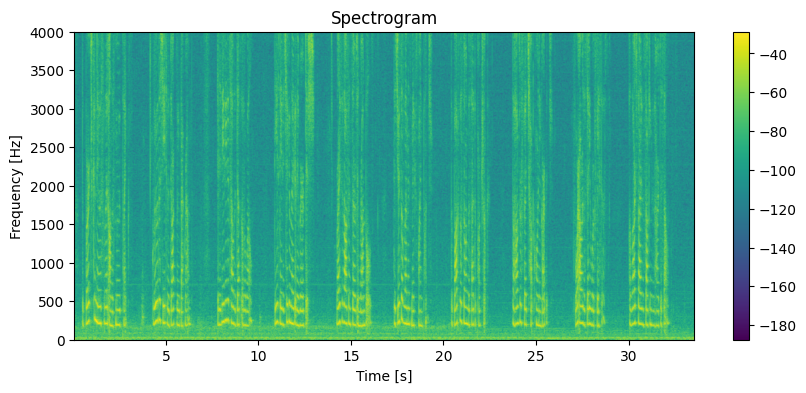

In [35]:
from asp_tools.utils.visualize import show_spectrogram_from_waveform
show_spectrogram_from_waveform(a, fs)

In [36]:
# from IPython.display import Audio

In [37]:
# 白色雑音を再生（音量注意！）
# Audio(data, rate=sample_freq) 

In [38]:
import sox

In [39]:
input_wav = "../data/OSR_us_000_0010_8k.wav"
output_wav = "../data/output.wav"

# トランスフォーマーをつくる（単一音声に対する処理）
transformer = sox.Transformer()

n_echos = 2  # エコー回数
delays = [375]  # 遅延時間 (ms)
decays = [0.5]  # 減衰率

# エコー回数分、遅延時間と減衰率を与える必要がある
# → エコー回数に等しい長さの「リスト」を 遅延時間と減衰率それぞれで用意する
# → n_echos が 2 なら遅延時間は [375, 750], 減衰率は [0.5, 0.25]
for i in range(1, n_echos):
    delays.append(delays[0] * (i + 1))  # 遅延時間は線形的
    decays.append(decays[0] ** (i + 1))  # 減衰率は指数的

# transformerにエコーを設定する
transformer.echo(n_echos=n_echos, delays=delays, decays=decays)

# エコーをかけた結果をファイルに保存
transformer.build(input_wav, output_wav)

# エコーをかけた結果をarrayとして取得
echos = transformer.build_array(input_wav)

output_file: ../data/output.wav already exists and will be overwritten on build


In [40]:
decays

[0.5, 0.25]

In [41]:
delays

[375, 750]

In [42]:
import librosa
import numpy as np

from asp_tools.utils.algorithms import gla

In [43]:
# Griffin-Lim iteration 10
iteration = 80
hop_length = 256
win_length = 512
n_fft = win_length
T = a.size

amp_spec = np.abs(librosa.core.stft(a, n_fft=n_fft, hop_length=hop_length, win_length=win_length))

est_phase_spec = gla(amp_spec, n_fft, win_length, hop_length, max_iteration=iteration)
est_spec = amp_spec * np.exp(1j * est_phase_spec)

est_signal = librosa.core.istft(est_spec, hop_length=hop_length, win_length=win_length)
est_signal
# estimated_signal = torch.istft(estimated_spectrogram, n_fft, hop_length=hop_length, window=win_length, length=T, onesided=True, return_complex=False)

array([0.02028708, 0.01847434, 0.01978757, ..., 0.01093192, 0.01060736,
       0.01070735])

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Spectrogram'}, xlabel='Time [s]', ylabel='Frequency [Hz]'>)

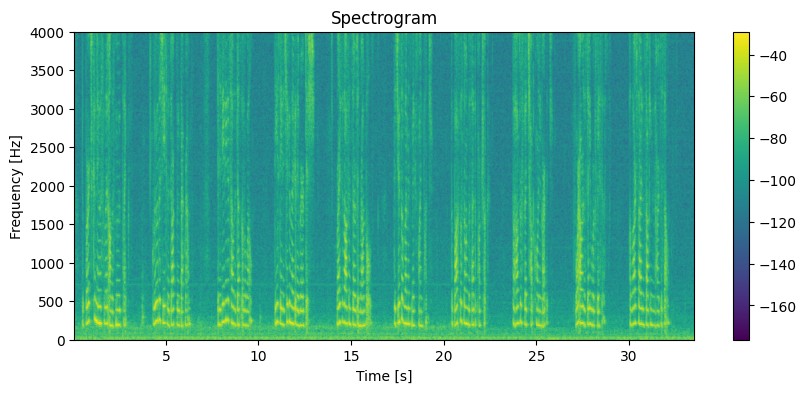

In [44]:
show_spectrogram_from_waveform(est_signal, fs)

In [45]:
from IPython.display import Audio

In [46]:
b = est_signal * 32768
b = np.clip(b, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

Audio(data=b, rate=fs)

In [31]:
a

array([378, 327, 270, ..., 241, 232, 235], dtype=int16)